### Using GPR to predict Flame Length

#### Import Libraries

In [65]:
# Sys
import os
import sys
import json
sys.path.append("..")

import pandas as pd
import numpy as np
from src.path import PATH_DATASETV1, PATH_DATA_FLAMELENGTH

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import KFold, cross_val_score, cross_val_predict
from sklearn.linear_model import Ridge
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern, WhiteKernel, ConstantKernel

from sklearn.metrics import mean_squared_error, r2_score

# plotting defaults
%matplotlib inline
sns.set(style="whitegrid")


#### Load and combine FlameLength.xlsx and DatasetV1.xlsx

In [41]:
# Load
df_main = pd.read_excel(PATH_DATASETV1)
df_fl = pd.read_excel(PATH_DATA_FLAMELENGTH)

# Merge on 'Name' column
df = pd.merge(df_main, df_fl, on="Name")

# show rows present only in the flame-length file
# only_in_flame = df_fl[~df_fl['Name'].isin(df_main['Name'])].copy()
# print(len(only_in_flame), "rows only in flame-length file")
print(len(df), "rows after merge")

# display IDs
# if len(only_in_flame):
#     display(only_in_flame[['Name']].head(50))
#     only_in_flame.to_csv(os.path.join(os.path.dirname(PATH_DATA_FLAMELENGTH), "only_in_flame.csv"), index=False)


# check for duplicates in merged dataframe
col = "Name"

print("Any duplicate IDs? ", df[col].duplicated().any())
print("Duplicate count (extra rows):", df[col].duplicated().sum())

# drop exact duplicates across all columns, keep first occurrence
df = df.drop_duplicates(keep="first")
print("Rows after dropping exact duplicates:", len(df))

# Rescale 'phiint' -> phi/(1+phi) and insert new column immediately after the original

# Convert to numeric just in case (non-numeric -> NaN)
phi = pd.to_numeric(df["PhiInt"], errors="coerce")

# Compute rescaled value
phi_rescaled = phi / (1 + phi)

# New column name
new_col = "PhiInt_rescaled"

# Insert new column immediately after 'phiint'
idx = df.columns.get_loc("PhiInt")
df.insert(loc=idx + 1, column=new_col, value=phi_rescaled)

# Quick verification
display(df[["PhiInt", new_col]].head(10))

57 rows after merge
Any duplicate IDs?  True
Duplicate count (extra rows): 9
Rows after dropping exact duplicates: 48


,PhiInt,PhiInt_rescaled
0,2.008448,0.667603
1,1.997066,0.666340
2,1.996639,0.666293
3,4.027794,0.801106
4,3.979560,0.799179
5,6.012267,0.857393
6,5.999513,0.857133
7,2.003487,0.667054
8,2.039250,0.670971
9,2.012097,0.668005


In [58]:
# feature selection and NA handling
# features = ["S1", "S2", "PhiInt_rescaled", "d1", "d2", "u1", "u2"]
features = ["S1", "S2", "d1", "d2", "u1"]
target = "Lf (m)"  # FlameLength

X = df[features].copy()
y = df[target].copy()

print("Feature matrix shape:", X.shape)

# Ridge baseline for comparison with GPR
pipeline_ridge = Pipeline([("scaler", StandardScaler()), ("ridge", Ridge(alpha=1.0))])
cv = KFold(n_splits=5, shuffle=True, random_state=1)
ridge_scores = -cross_val_score(
    pipeline_ridge, X, y, cv=cv, scoring="neg_root_mean_squared_error"
)
print(f"Ridge CV RMSE: mean={ridge_scores.mean():.3f}, std={ridge_scores.std():.3f}")

Feature matrix shape: (48, 5)
Ridge CV RMSE: mean=0.019, std=0.003


d:\Users\fengchonghui\Documents\chong hui\centralesupelec\Rozanoff\rozanoff_2025\rozanoff_env\Lib\site-packages\sklearn\gaussian_process\kernels.py:450: ConvergenceWarning: The optimal value found for dimension 3 of parameter k1__k2__length_scale is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


GPR CV RMSE: mean=0.016, std=0.006
Fitted kernel: 0.682**2 * Matern(length_scale=[2.01, 1.02, 1.57, 4.01, 1.91], nu=2.5) + WhiteKernel(noise_level=0.015)
Log-marginal-likelihood: -3.173980999454777
Train RMSE: 0.006, Train R2: 0.992


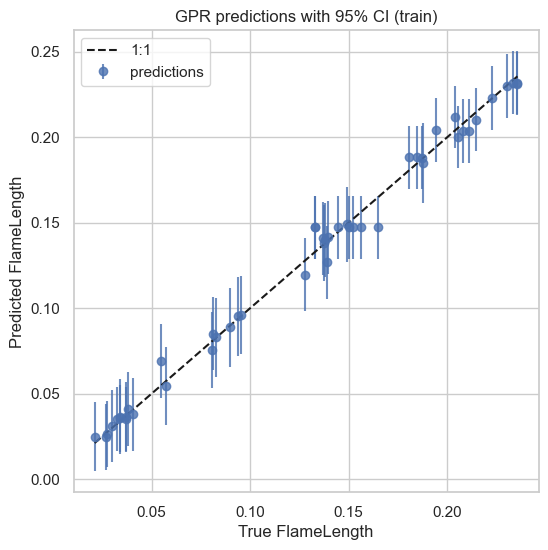

d:\Users\fengchonghui\Documents\chong hui\centralesupelec\Rozanoff\rozanoff_2025\rozanoff_env\Lib\site-packages\sklearn\gaussian_process\kernels.py:450: ConvergenceWarning: The optimal value found for dimension 3 of parameter k1__k2__length_scale is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


Ridge OOF: RMSE = 0.01888, R2 = 0.92536
GPR   OOF: RMSE = 0.01747, R2 = 0.93605


In [67]:
# GPR with Matern (ARD) + WhiteKernel; use ARD by passing a vector length_scale
kernel = ConstantKernel(1.0, (1e-2, 1e2)) * Matern(
    length_scale=np.ones(X.shape[1]), length_scale_bounds=(1e-3, 1e3), nu=2.5
) + WhiteKernel(noise_level=1.0, noise_level_bounds=(1e-6, 1e2))

gpr = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=8, normalize_y=True)
pipeline_gpr = Pipeline([("scaler", StandardScaler()), ("gpr", gpr)])

# Cross-validated RMSE (5-fold)
gpr_scores = -cross_val_score(
    pipeline_gpr, X, y, cv=cv, scoring="neg_root_mean_squared_error", n_jobs=1
)
print(f"GPR CV RMSE: mean={gpr_scores.mean():.3f}, std={gpr_scores.std():.3f}")

# fit on full data and diagnostics
pipeline_gpr.fit(X, y)
gpr_fitted = pipeline_gpr.named_steps["gpr"]
print("Fitted kernel:", gpr_fitted.kernel_)
print("Log-marginal-likelihood:", gpr_fitted.log_marginal_likelihood_value_)

# Predict on training data for diagnostics
X_scaled = pipeline_gpr.named_steps["scaler"].transform(X)
y_pred, y_std = gpr_fitted.predict(X_scaled, return_std=True)

train_rmse = np.sqrt(mean_squared_error(y, y_pred))
train_r2 = r2_score(y, y_pred)
print(f"Train RMSE: {train_rmse:.3f}, Train R2: {train_r2:.3f}")

# plot predicted vs true with 95% CI
plt.figure(figsize=(6, 6))
plt.errorbar(y, y_pred, yerr=1.96 * y_std, fmt="o", alpha=0.8, label="predictions")
plt.plot([y.min(), y.max()], [y.min(), y.max()], "k--", label="1:1")
plt.xlabel("True FlameLength")
plt.ylabel("Predicted FlameLength")
plt.legend()
plt.title("GPR predictions with 95% CI (train)")
plt.show()

# pipeline_ridge and pipeline_gpr should be defined; cv is your KFold
y_oof_ridge = cross_val_predict(pipeline_ridge, X, y, cv=cv, n_jobs=1)
y_oof_gpr   = cross_val_predict(pipeline_gpr,   X, y, cv=cv, n_jobs=1)

def rmse(a,b): 
    return np.sqrt(mean_squared_error(a,b))

print("Ridge OOF: RMSE = {:.5f}, R2 = {:.5f}".format(rmse(y, y_oof_ridge), r2_score(y, y_oof_ridge)))
print("GPR   OOF: RMSE = {:.5f}, R2 = {:.5f}".format(rmse(y, y_oof_gpr),   r2_score(y, y_oof_gpr)))

In [62]:
# inspect length-scales from fitted kernel
kernel_repr = gpr_fitted.kernel_
print("Kernel repr:", kernel_repr)

# Try to extract length_scale values from the kernel string if structured; otherwise print kernel and infer
# Note: sklearn exposes parameters via kernel_.get_params() but the nested structure can differ
params = gpr_fitted.kernel_.get_params()
# look for attributes named 'length_scale' in params
ls = {k: v for k, v in params.items() if "length_scale" in k}
print("Length-scale params found:", ls)

Kernel repr: 0.682**2 * Matern(length_scale=[2.01, 1.02, 1.57, 4.01, 1.91], nu=2.5) + WhiteKernel(noise_level=0.015)
Length-scale params found: {'k1__k2__length_scale': array([2.00981266, 1.02346459, 1.57215933, 4.00746216, 1.91030876]), 'k1__k2__length_scale_bounds': (0.001, 1000.0)}


In [ ]:
# Cell 11: save cleaned merged data and trained pipeline
out_csv = os.path.join(os.path.dirname(PATH_DATASETV1), "merged_cleaned_with_flame.csv")
df.to_csv(out_csv, index=False)
print("Saved merged data to", out_csv)

import joblib

model_path = os.path.join(os.path.dirname(PATH_DATASETV1), "gpr_pipeline.joblib")
joblib.dump(pipeline_gpr, model_path)
print("Saved pipeline to", model_path)